In [1]:
import numpy as np
import chainer
from chainer import cuda,  Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain
import chainer.functions as F
import chainer.links as L
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
import pickle as pickle
from matplotlib import cm
%matplotlib inline 

In [2]:
import glob
from PIL import Image
from itertools import product
from scipy.misc import imresize
def break_up(img):
    h = np.arange(0,img.shape[0]+64,64)
    w = np.arange(0,img.shape[1]+64,64)
    img_list = []
    for k,i in product(range(len(h)-1),range(len(w)-1)):
        temp = img[h[k]:h[k+1],w[i]:w[i+1],0:3]
        img_list.append(imresize(temp,(28,28,3)))
    return np.array(img_list)


#img_list = glob.glob('./dot/4_unit/*')
img_dir_list = glob.glob('./dot/3_sv_actors/*')

for k in range(len(img_dir_list)):
    if np.mod(k,100)==0:
        print(k)
    img_name = img_dir_list[k]
    img = Image.open(img_name)
    img = np.asarray(img)
    img = break_up(img)
    if k == 0:
        img_list = img
    else:
        img_list = np.vstack([img_list,img])

0
100
200
300
400
500
600
700
800
900
1000
1100


In [3]:
img = img_list.transpose(0,3,1,2)/255.0
n_data = len(img)
r = np.random.permutation(n_data)
train_rate = 0.8
n_train = int(train_rate * n_data)
x_train = img[r[:n_train]]
x_test  = img[r[n_train:]]

In [6]:
class Decoder(chainer.Chain):
    def __init__(self):
        super(Decoder, self).__init__(
            l1=L.Linear(z_dim,512*3*3),
            dcv1=L.Deconvolution2D(in_channels=512,out_channels=256,ksize=2,stride=2,pad=1),
            dcv2=L.Deconvolution2D(in_channels=256,out_channels=128,ksize=2,stride=2,pad=1),
            dcv3=L.Deconvolution2D(in_channels=128,out_channels=64,ksize=2,stride=2,pad=1),
            dcv4=L.Deconvolution2D(in_channels=64,out_channels=3,ksize=3,stride=3,pad=1),
            bn1=L.BatchNormalization(size=512),
            bn2=L.BatchNormalization(size=256),
            bn3=L.BatchNormalization(size=128),
            bn4=L.BatchNormalization(size=64),
        )
    def __call__(self,z):
        x = F.reshape(self.l1(z),(z.data.shape[0],512,3,3))
        x=self.dcv1(F.relu((x)))
        x=self.dcv2(F.relu((x)))
        x=self.dcv3(F.relu((x)))
        x=self.dcv4(F.relu((x)))
        return F.sigmoid(x)
    

In [7]:
class Encoder(chainer.Chain):
    def __init__(self):
        super(Encoder,self).__init__(
            conv1=L.Convolution2D(in_channels=3,out_channels=64,ksize=3,stride=3,pad=1),
            conv2=L.Convolution2D(in_channels=64,out_channels=128,ksize=2,stride=2,pad=1),
            conv3=L.Convolution2D(in_channels=128,out_channels=256,ksize=2,stride=2,pad=1),
            conv4=L.Convolution2D(in_channels=256,out_channels=512,ksize=2,stride=2,pad=1),
            
            bc1=L.BatchNormalization(size=128),
            bc2=L.BatchNormalization(size=256),
            bc3=L.BatchNormalization(size=512),
            fc=L.Linear(3*3*512,z_dim * 2)
        )
    def __call__(self,x):
        h=F.relu((self.conv1(x)))
        h=F.relu((self.conv2(h)))
        h=F.relu((self.conv3(h)))
        h=F.relu((self.conv4(h)))
        h=self.fc(h)
        
        return h
        


In [8]:
def var_float(x):
    return Variable(cuda.to_gpu(x.astype(np.float32)))
    
def var_int(x):
    return Variable(cuda.to_gpu(x.astype(np.int32)))
    

In [23]:
z_dim = 300

E=Encoder()
D=Decoder()

E.to_gpu()
D.to_gpu()

In [24]:

opt_e = optimizers.Adam(alpha=0.002, beta1=0.5)
opt_d = optimizers.Adam(alpha=0.002, beta1=0.5)
opt_e.setup(E)
opt_d.setup(D)
# opt_e.add_hook(chainer.optimizer.WeightDecay(0.0001))
# opt_d.add_hook(chainer.optimizer.WeightDecay(0.0001))


In [ ]:
bs=200
ones = var_float(np.ones([bs,z_dim]))
lossE_hist=[]
lossD_hist=[]
for i in range(50000):
    if np.mod(i,10)==0:
        print i
    
    #random sampling true image
    r=np.random.permutation(len(x_train))
    x=var_float(x_train[r[0:bs],:])
    
    #get latent variable
    z = E(x)
    z_sig = z[:,:z_dim]
    z_mu  = z[:,z_dim:]
    z = z_sig * np.random.randn() + z_mu

    #decode
    y = D(z)

    #loss
    temp = z_sig ** 2
    lossE = - 0.5 * F.mean(- temp + F.log(temp + 1e-8) - z_mu**2 + ones) 
    lossD = - F.mean(x*F.log(y+1e-8) + (1-x) * F.log(1-y+1e-8))
    loss =  lossD #+ lossE

    #update
    E.cleargrads()
    D.cleargrads()

    loss.backward() 
    
    opt_e.update()
    opt_d.update()
    
    lossE_hist.append(lossE.data)
    lossD_hist.append(lossD.data)

#     print('----')
#     print(lossE.data)
#     print(lossD.data)
# plt.subplot(1,2,1)
# plt.plot(lossE_hist)
# plt.subplot(1,2,2)
# plt.plot(lossD_hist)

In [51]:
def recon(img):
    z = E(var_float(img))
    z = z[0:1,z_dim:]
    return cuda.to_cpu(D(z).data)[0]

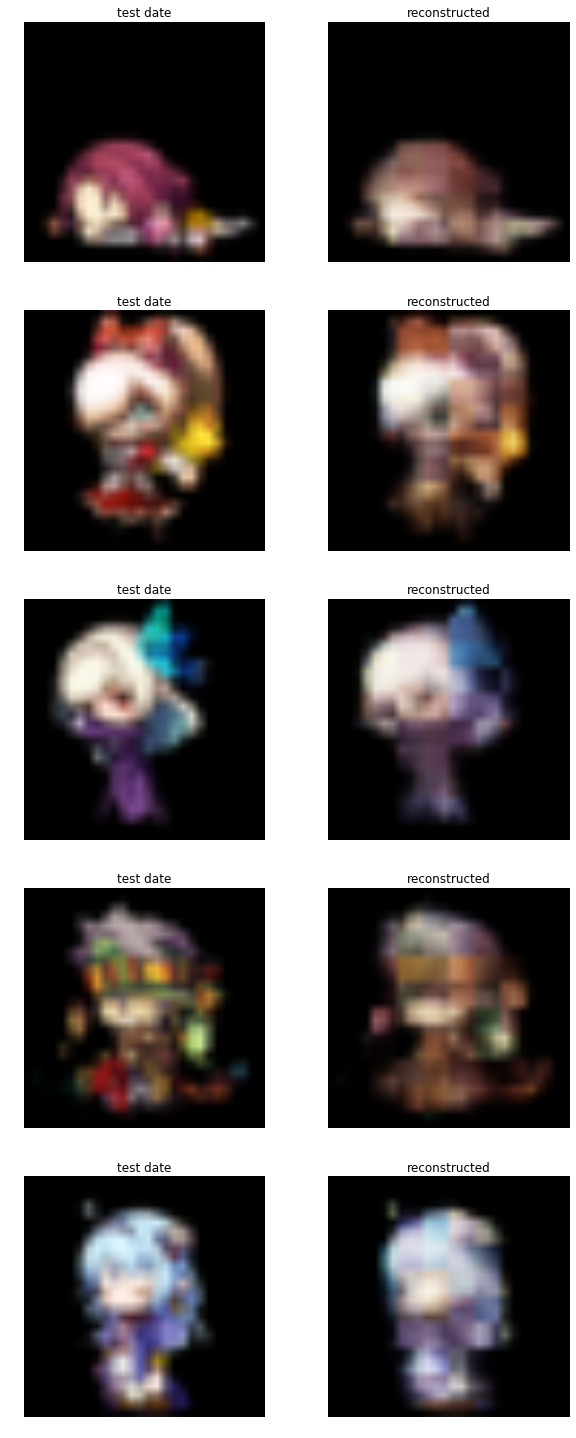

In [58]:
r=np.random.permutation(len(x_test))
plt.figure(figsize=[10,25])
for k in range(5):
    plt.subplot(5,2,2*k+1)
    img = x_test[r[k]:r[k]+1]
    plt.imshow(img[0].transpose(1,2,0))
    plt.axis('off')
    plt.title('test date')
    plt.subplot(5,2,2*k+2)           
    plt.imshow(recon(img).transpose(1,2,0))
    plt.axis('off')
    plt.title('reconstructed')
plt.savefig('dot_reconstructed_vae')

In [59]:

def linear_interpolation(base,target,n_step):
    d = target - base
    step = d/(n_step - 1)

    z_list = []
    for k in range(n_step):
        z_list.append(base + step * k)
    z_list = np.vstack(z_list)
    return z_list

In [65]:
# latent variable for one of each class image
z_list_each_img = []
img_list = []
r = np.random.permutation(len(x_test))
for k in range(10):
    img = x_test[r[k]:r[k]+1]
    img_list.append(img)
    z = E(var_float(img))
    z_list_each_img.append(cuda.to_cpu(np.mean(z.data[:,z_dim:],axis=0)))

#linear interpolation
z_list = []
n_interpolation = 10
for k in range(10):
    if k<9:
        temp = linear_interpolation(z_list_each_img[k],z_list_each_img[k+1],n_interpolation)
    if k==9:
        temp = linear_interpolation(z_list_each_img[9],z_list_each_img[0],n_interpolation)
    z_list.append(temp)

z_list = np.vstack(z_list)
img = cuda.to_cpu(D(var_float(z_list)).data)

In [66]:
def imshow_multi(x,c=5,r=5):
    fig=plt.figure(figsize=[15,15])
    for i in range(r*c):
        plt.subplot(r,c,i+1)
        plt.imshow(x[i,:].transpose(1,2,0))
        plt.gray()

        plt.tick_params(labelbottom='off')
        plt.tick_params(labelleft='off')

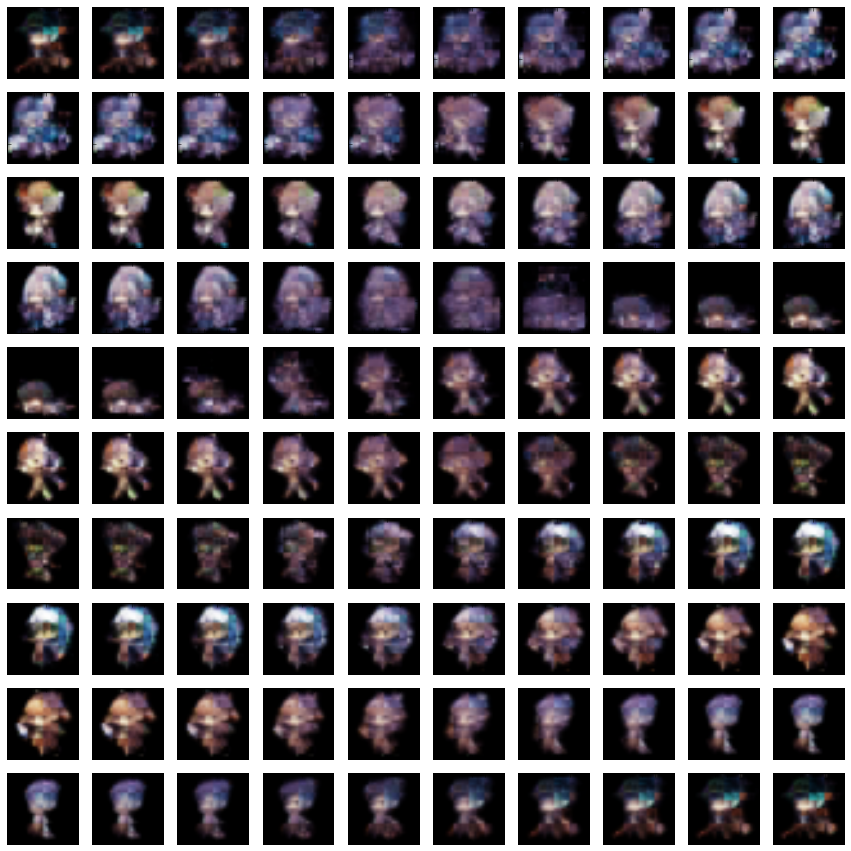

In [67]:
imshow_multi(img,10,10)
plt.savefig('dot_interpolation_vae')